# Align measured with annotated spectra

In [ ]:

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

import pandas as pd
import matchms
from matchms.importing import load_from_msp
from data_utils import spectrum_processing
from pipeline_utils import get_galaxy_filename

def get_spectra(path):
    spectrums = [spectrum_processing(s, min_rel_int=None, n_required_peaks=1) for s in load_from_msp(path, metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    return spectrums

In [4]:
model = "Original"

ground = pd.read_csv("tmp/6_KC_Confirmed_seminalplasma.csv.csv")
library = get_spectra("tmp/5_rcx_gc-orbitrap_metabolites_20210817.msp.msp")
measured = get_spectra(get_galaxy_filename(f"_{model}", "tmp"))
matches = pd.read_csv(get_galaxy_filename(f"- {model}", "tmp"), sep="\t")

In [5]:
ground["RT"] = ground["Average Rt(min)"]*60
ground = ground.sort_values(by=['RT'], ascending=True) 

In [6]:
# super inefficent variant :))
def get_RTI(c_ids, measured):
    rts =[]
    ris = []
    for c_id in c_ids:
        for spectrum in measured:
            if c_id == spectrum.metadata["compound_name"]:
                rts.append(spectrum.metadata["retention_time"])
                ris.append(spectrum.metadata["retention_index"])
                break
    return rts, ris
matches["RT"], matches["RI"] = get_RTI(matches["query"], measured)

matches = matches.sort_values(by=['RT'], ascending=True) 

In [7]:
measured[0].metadata

{'ionmode': 'Negative',
 'spectrumtype': 'Centroid',
 'num_peaks': '13',
 'compound_name': 'C21',
 'retention_time': '121.71',
 'retention_index': '1077.94686'}

In [8]:
# select library spectra present in ground
ground

# add RT column to the selected library spectra


# sort selected library spectra by RT

,Average Rt(min),Average RI,Metabolite name,RT
0,2.484,1224.68,2-Methylmalonic acid_2TMS,149.04
33,2.615,1266.17,Leucine_2TMS,156.90
31,2.691,1288.34,Isoleucine_2TMS,161.46
47,2.718,1296.42,Proline_2TMS,163.08
26,2.744,1303.46,Glycine_3TMS,164.64
...,...,...,...,...
57,5.793,2234.36,Stearic acid_1TMS,347.58
55,5.832,2247.44,Spermidine_5TMS,349.92
56,7.086,2740.02,Spermine_6TMS,425.16
37,8.709,3529.40,Maltotriose_11TMS isomer 1,522.54


In [9]:
matches

,query,reference,matches,score,RT,RI
85,C31,Alanine_2TMS,1,0.000124,130.03,1129.444444
52,C18,Urea_3TMS,1,0.003368,142.54,1192.626263
105,C47,Valine_2TMS,3,0.884027,146.05,1210.04902
106,C48,Urea_2TMS,2,0.566104,149.88,1228.823529
125,C62,Isoleucine_2TMS,1,0.902625,160.87,1282.696078
...,...,...,...,...,...,...
33,C10,Acetylgalactosamine_5TMS isomer 1,5,0.108570,322.28,2087.111111
32,C10,Acetylgalactosamine_4TMS,5,0.103987,322.28,2087.111111
31,C10,3-Indolepropionic acid,1,0.003518,322.28,2087.111111
98,C40,Stearic acid_1TMS,6,0.417295,347.74,2238.555556


In [10]:
# from dtw import *
# alignment = dtw(query, template, keep_internals=True)

In [62]:
matches["grank"] = matches.groupby("query")["score"].rank("dense", ascending=False)

In [67]:
matches[matches["query"] =="C10"]

,query,reference,matches,score,RT,RI,grank
39,C10,Uric acid_4TMS,3,0.006264,322.28,2087.111111,7.0
38,C10,Myo-inositol_6TMS,13,0.915567,322.28,2087.111111,1.0
37,C10,Indole-3-acetamide_2TMS,1,0.003071,322.28,2087.111111,9.0
36,C10,Acetylglucosamine_5TMS isomer 2,6,0.142404,322.28,2087.111111,2.0
35,C10,Acetylglucosamine_5TMS isomer 1,6,0.122273,322.28,2087.111111,4.0
34,C10,Acetylgalactosamine_5TMS isomer 2,6,0.130977,322.28,2087.111111,3.0
33,C10,Acetylgalactosamine_5TMS isomer 1,5,0.108570,322.28,2087.111111,5.0
32,C10,Acetylgalactosamine_4TMS,5,0.103987,322.28,2087.111111,6.0
31,C10,3-Indolepropionic acid,1,0.003518,322.28,2087.111111,8.0


In [77]:
list(matches.reference)[0]

'Alanine_2TMS'

174

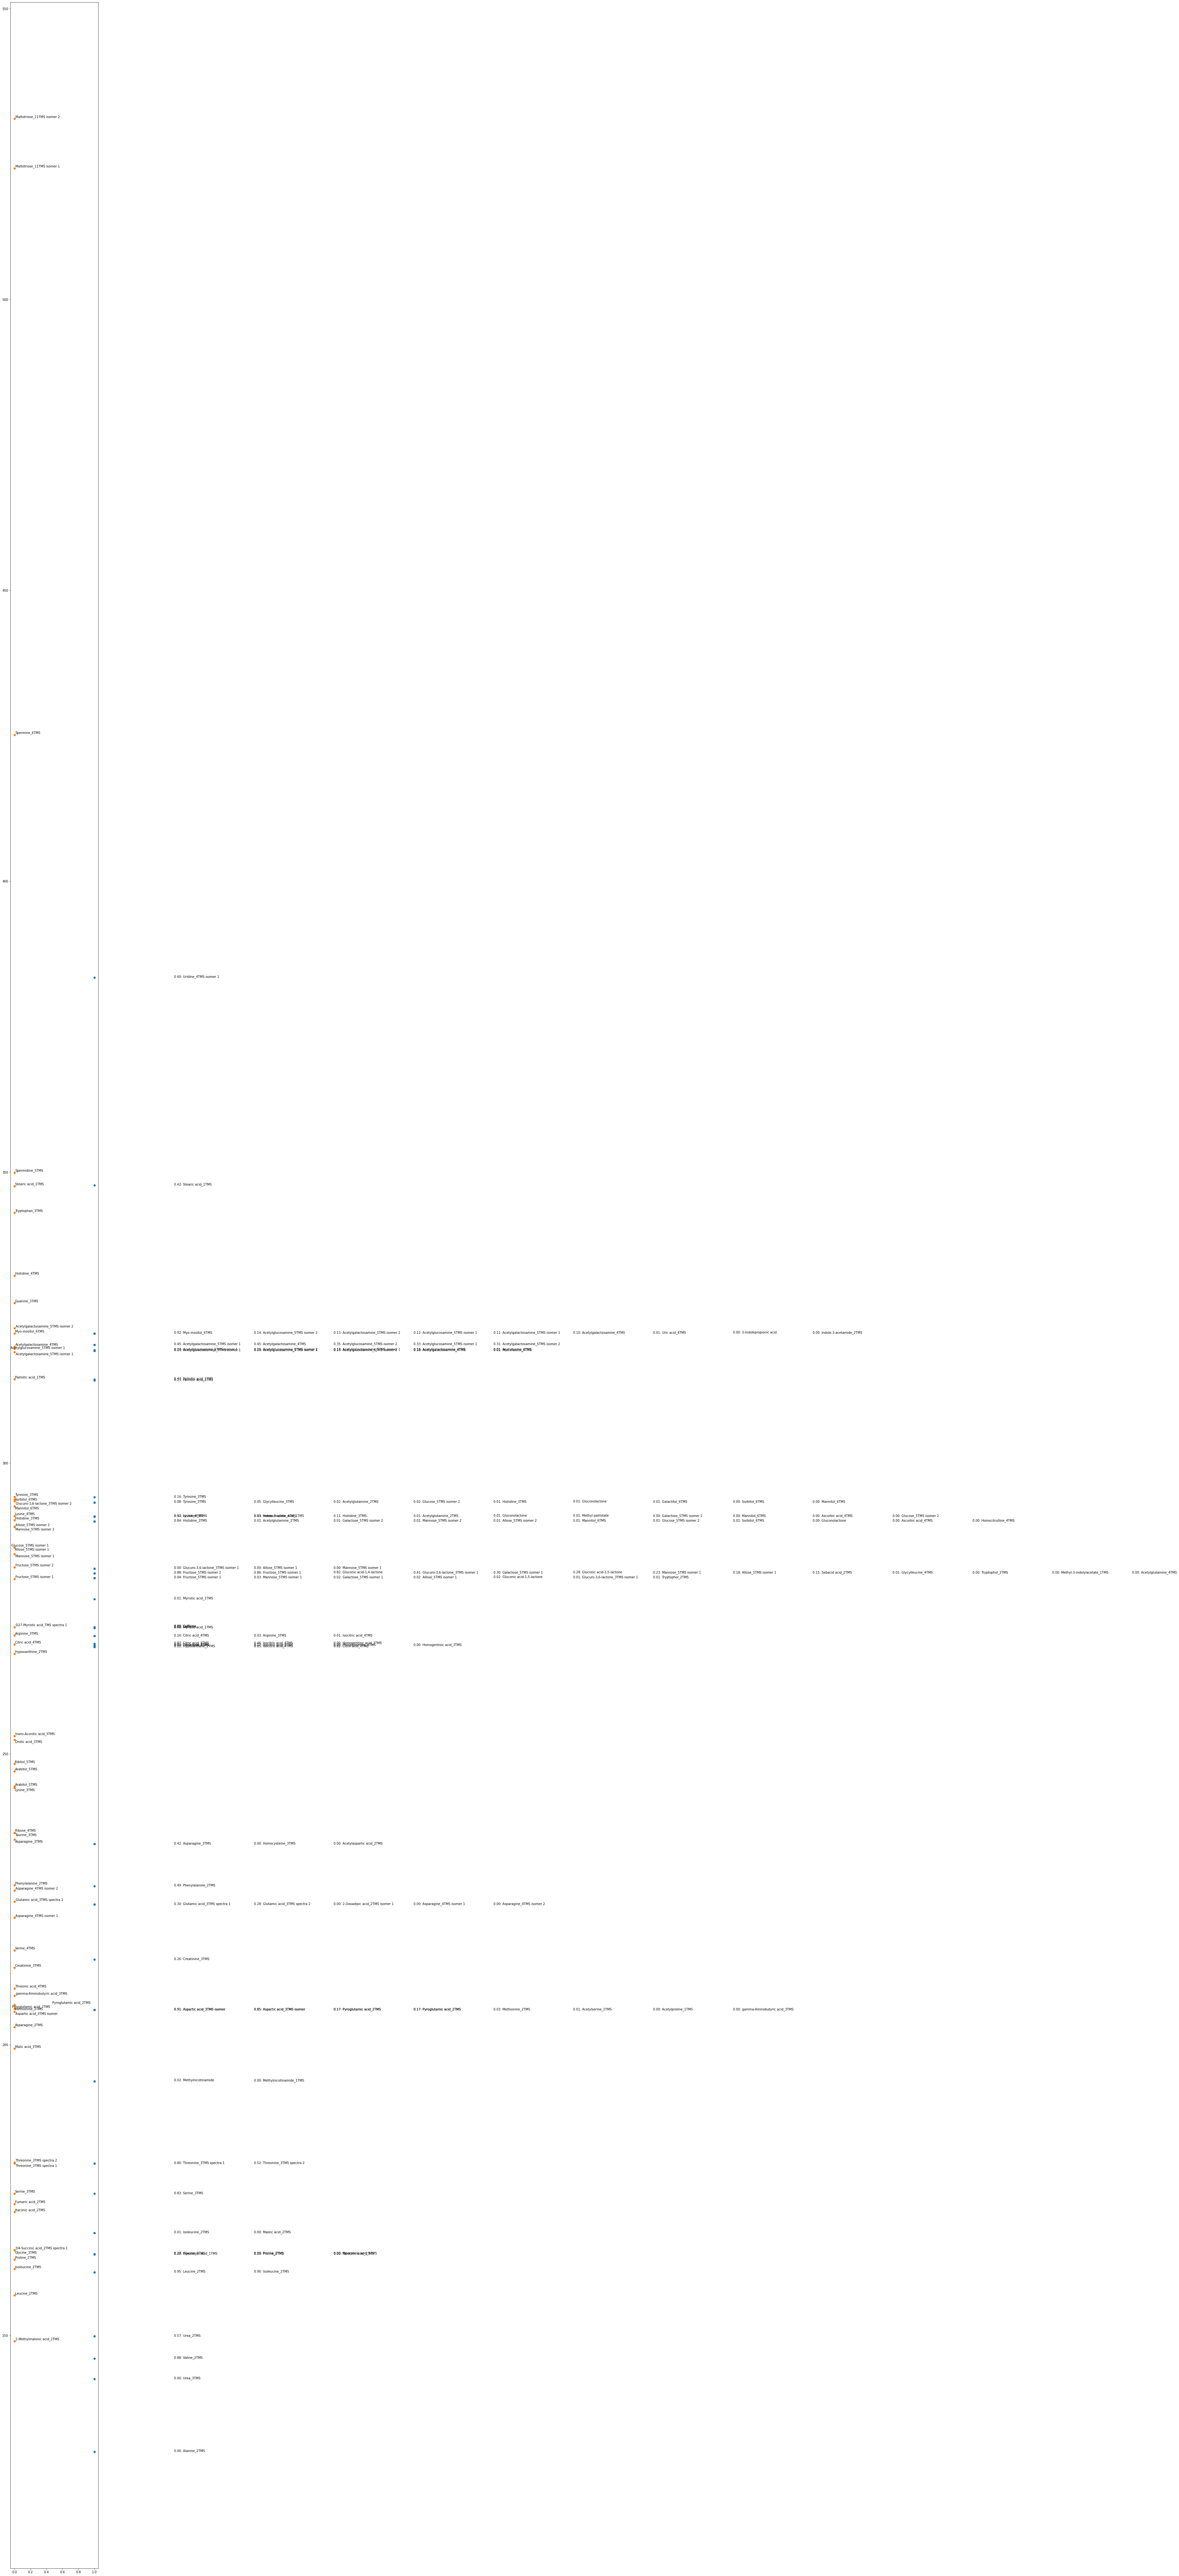

In [81]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
y1 = list(matches.RT.astype(float))
y2 = list(ground.RT)
x1,x2 = np.repeat(1, len(matches)), np.repeat(0, len(ground))
n1,ranks, scores = list(matches.reference), list(matches.grank), list(matches.score)
n2 = list(ground["Metabolite name"])

fig, ax = plt.subplots(figsize=(5, 150))
ax.scatter(x1, y1)
ax.scatter(x2, y2)

texts = []
adjust_text(texts)

for i, (txt, rank, score) in enumerate(zip(n1,ranks, scores)):
#     texts.append(plt.text(x1[i]+rank, y1[i], txt, ha='center', va='center'))
    ax.annotate(f"{score:.2f}: {txt}", (x1[i] + rank, y1[i]), annotation_clip=False)
for i, txt in enumerate(n2):
    texts.append(plt.text(x2[i], y2[i], txt, ha='center', va='center'))
#     ax.annotate(txt, (x2[i], y2[i]))
adjust_text(texts)


In [12]:
y1.to_list()

[130.03,
 142.54,
 146.05,
 149.88,
 160.87,
 160.87,
 163.98,
 163.98,
 163.98,
 164.01,
 164.01,
 164.01,
 167.64,
 167.64,
 174.39,
 179.57,
 179.57,
 193.74,
 193.74,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 205.97,
 214.64,
 224.1,
 224.1,
 224.1,
 224.1,
 224.1,
 227.25,
 234.48,
 234.48,
 234.48,
 268.4,
 268.4,
 268.4,
 268.59,
 268.59,
 268.59,
 268.59,
 268.63,
 268.92,
 268.92,
 268.92,
 270.25,
 270.25,
 270.25,
 271.64,
 271.72,
 271.8,
 276.62,
 280.23,
 280.23,
 280.23,
 280.23,
 280.23,
 280.23,
 280.23,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.05,
 281.87,
 281.87,
 281.87,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 289.95,
 290.78,
 290.78,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 290.8,
 293.21,
 293.21,
 293.21,
 293.21,
 293.21,
 293.21,
 293.21,
 293.21,
 2

In [13]:
y2.to_list()

[149.04,
 156.9,
 161.46,
 163.07999999999998,
 164.64,
 164.70000000000002,
 171.23999999999998,
 172.61999999999998,
 174.42000000000002,
 179.58,
 179.76000000000002,
 199.32,
 203.04,
 205.68,
 206.16000000000003,
 206.76000000000002,
 206.88,
 208.44,
 209.70000000000002,
 213.23999999999998,
 216.23999999999998,
 221.82,
 224.58,
 226.5,
 227.4,
 235.26000000000002,
 236.4,
 236.46,
 244.14,
 244.38000000000002,
 247.02,
 248.28,
 252.42,
 253.07999999999998,
 267.18,
 268.8,
 270.36,
 271.8,
 280.08,
 282.06000000000006,
 284.34,
 285.48,
 285.48,
 288.96,
 289.02,
 290.16,
 290.88,
 292.56,
 293.4,
 293.76,
 294.18,
 314.40000000000003,
 319.08,
 319.67999999999995,
 319.97999999999996,
 322.26000000000005,
 323.16,
 327.47999999999996,
 332.22,
 343.02000000000004,
 347.5799999999999,
 349.9200000000001,
 425.16,
 522.54,
 531.0600000000001]

In [14]:
ground

,Average Rt(min),Average RI,Metabolite name,RT
0,2.484,1224.68,2-Methylmalonic acid_2TMS,149.04
33,2.615,1266.17,Leucine_2TMS,156.90
31,2.691,1288.34,Isoleucine_2TMS,161.46
47,2.718,1296.42,Proline_2TMS,163.08
26,2.744,1303.46,Glycine_3TMS,164.64
...,...,...,...,...
57,5.793,2234.36,Stearic acid_1TMS,347.58
55,5.832,2247.44,Spermidine_5TMS,349.92
56,7.086,2740.02,Spermine_6TMS,425.16
37,8.709,3529.40,Maltotriose_11TMS isomer 1,522.54


In [15]:
measured[0].metadata

{'ionmode': 'Negative',
 'spectrumtype': 'Centroid',
 'num_peaks': '13',
 'compound_name': 'C21',
 'retention_time': '121.71',
 'retention_index': '1077.94686'}

In [16]:
annotated = []
for i, row in ground.iterrows():
    c = row["Metabolite name"]
    for s in library:
        if s.metadata["compound_name"] == c:
            annotated.append((s, row["RT"]))
            break
    


In [17]:
measured[0].metadata

{'ionmode': 'Negative',
 'spectrumtype': 'Centroid',
 'num_peaks': '13',
 'compound_name': 'C21',
 'retention_time': '121.71',
 'retention_index': '1077.94686'}

In [27]:
annotated[0][0].metadata

{'scannumber': '-1',
 'precursortype': '[M]+',
 'ionmode': 'Positive',
 'spectrumtype': 'Centroid',
 'formula': 'C10H22O4Si2',
 'inchikey': 'LJDAAXOEMCESSS-UHFFFAOYSA-N',
 'inchi': '',
 'smiles': 'O=C(O[Si](C)(C)C)C(C(=O)O[Si](C)(C)C)C',
 'authors': 'Price et al., RECETOX, Masaryk University (CZ)',
 'instrument': 'Q Exactive GC Orbitrap GC-MS/MS',
 'instrumenttype': 'GC-EI-Orbitrap',
 'ionization': 'EI+',
 'license': 'CC BY-NC',
 'comment': '',
 'peak_comments': {73.04682: 'Theoretical m/z 73.046802, Mass diff 0 (0.24 ppm), SMILES C[SiH](C)C, Annotation [C3H10Si-H]+, Rule of HR True',
  75.0261: 'Theoretical m/z 75.026065, Mass diff 0 (0.46 ppm), SMILES O[SiH](C)C, Annotation [C2H8OSi-H]+, Rule of HR True',
  129.03662: 'Theoretical m/z 129.03663, Mass diff 0 (0.08 ppm), SMILES O=C(O[SiH](C)C)CC, Annotation [C5H12O2Si-3H]+, Rule of HR True',
  131.03432: 'Theoretical m/z 131.034434, Mass diff 0 (0 ppm), Formula C5H7O4',
  133.01353: 'Theoretical m/z 133.014108, Mass diff 0 (0 ppm), For

## add manually unmatched compounds

In [28]:
unmatched = {'2-Methylmalonic acid_2TMS',
 'Allose_5TMS isomer 2',
 'Arabitol_5TMS',
 'Asparagine_2TMS',
 'Asparagine_4TMS isomer 2',
 'D27-Myristic acid_TMS spectra 1',
 'D4-Succinic acid_2TMS spectra 1',
 'Fumaric acid_2TMS',
 'Glucose_5TMS isomer 1',
 'Glucuro-3,6-lactone_3TMS isomer 2',
 'Guanine_3TMS',
 'Histidine_4TMS',
 'Hypoxanthine_2TMS',
 'Isoleucine_2TMS',
 'Itaconic acid_2TMS',
 'Leucine_2TMS',
 'Lysine_3TMS',
 'Malic acid_3TMS',
 'Maltotriose_11TMS isomer 1',
 'Maltotriose_11TMS isomer 2',
 'Mannitol_6TMS',
 'Mannose_5TMS isomer 2',
 'Methionine_2TMS',
 'Orotic acid_3TMS',
 'Pyroglutamic acid_2TMS',
 'Ribitol_5TMS',
 'Ribose_4TMS',
 'Serine_4TMS',
 'Spermidine_5TMS',
 'Spermine_6TMS',
 'Taurine_3TMS',
 'Threonic acid_4TMS',
 'Tryptophan_3TMS',
 'gamma-Aminobutyric acid_3TMS',
 'trans-Aconitic acid_3TMS'}

In [38]:
def get_close(RT, meas, window=3):
    res = []
    for spectrum in meas:
        if abs(float(spectrum.metadata["retention_time"]) - RT) < window:
            res.append(spectrum)
    return res

In [39]:
get_close(120,measured)

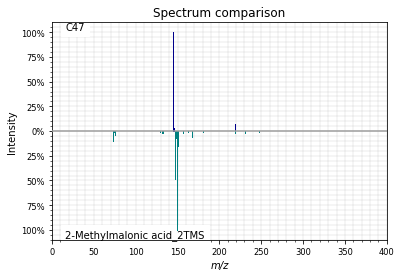

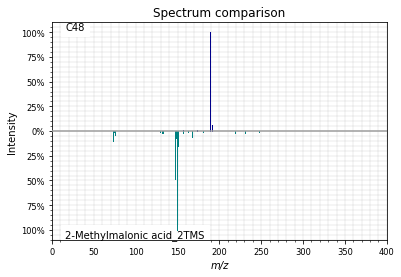

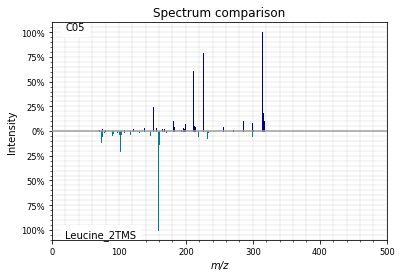

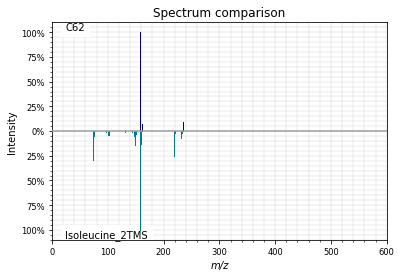

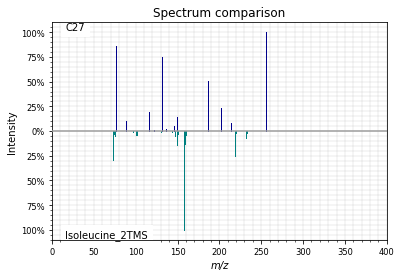

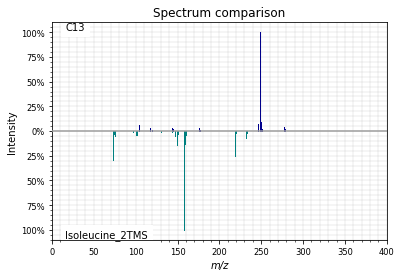

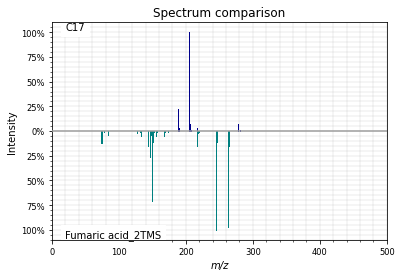

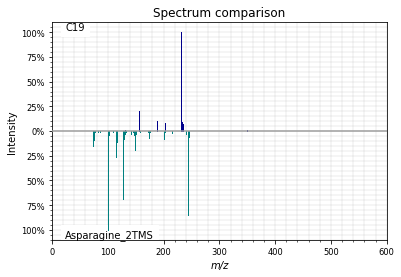

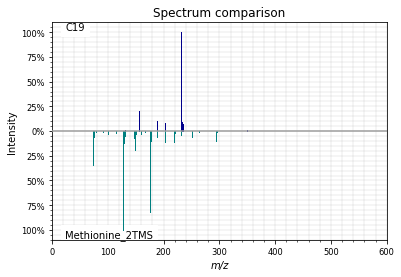

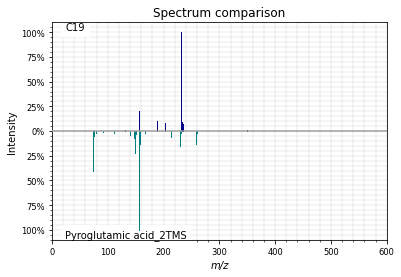

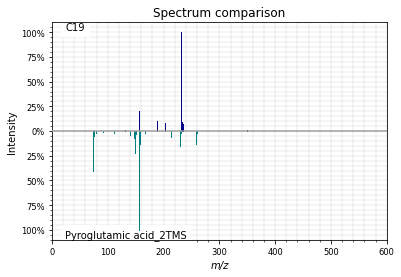

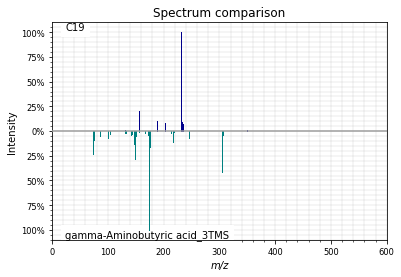

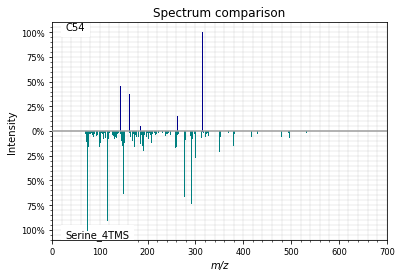

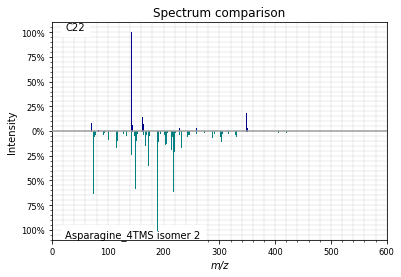

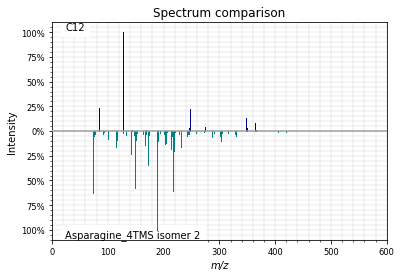

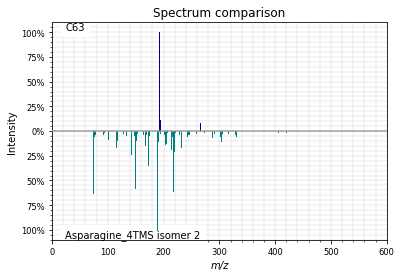

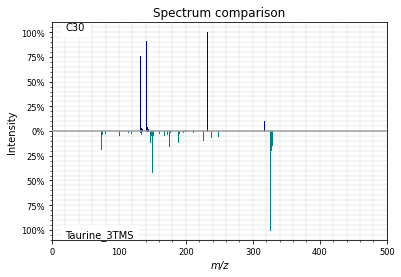

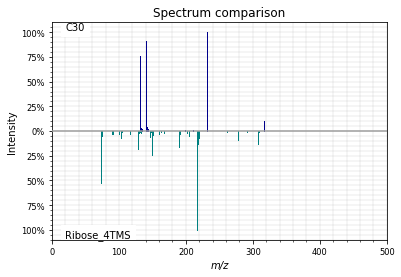

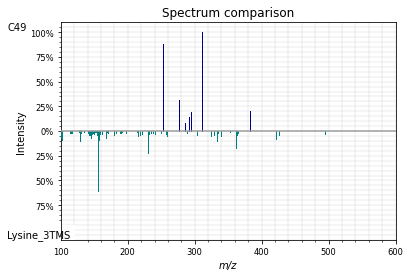

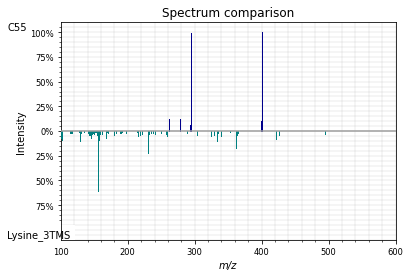

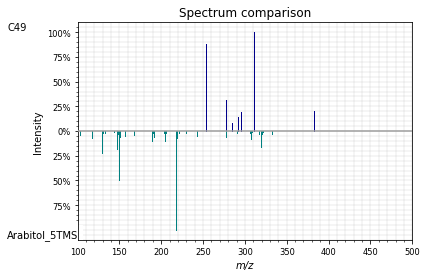

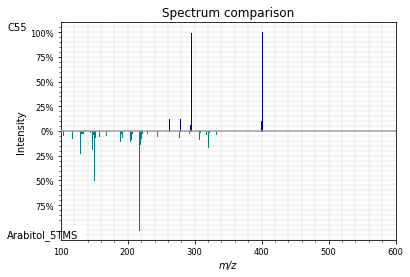

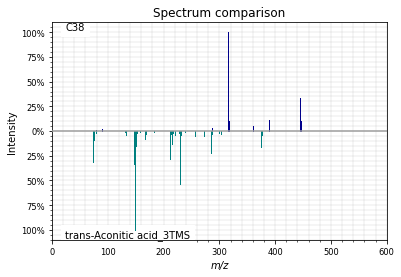

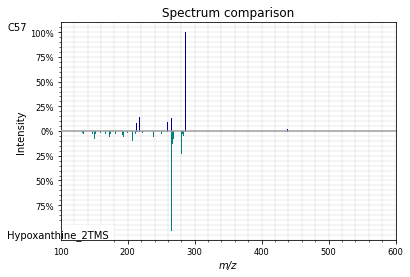

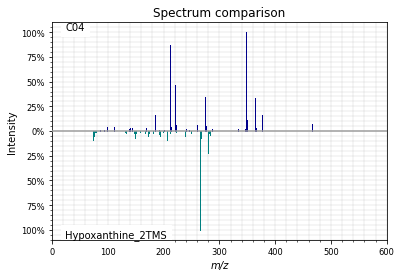

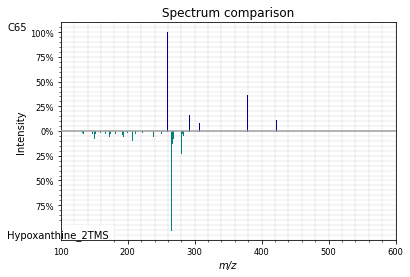

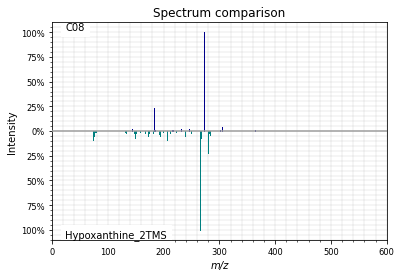

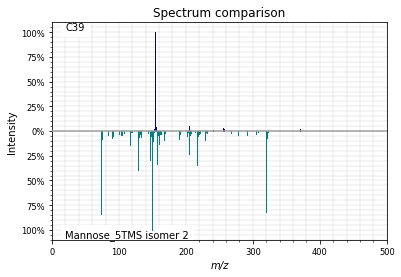

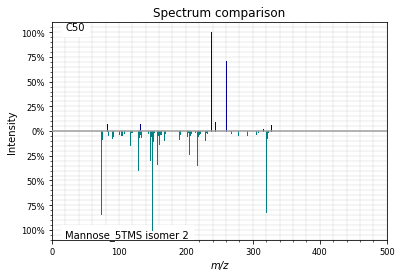

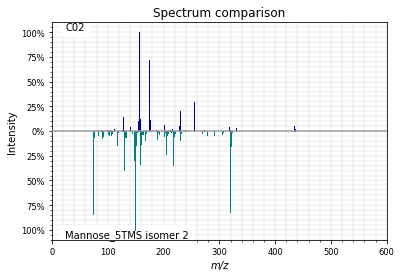

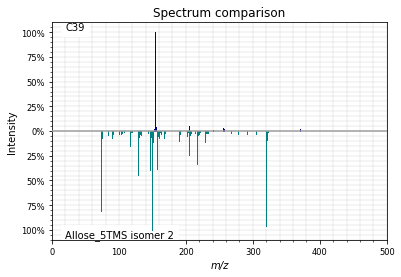

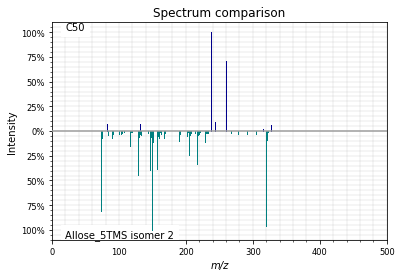

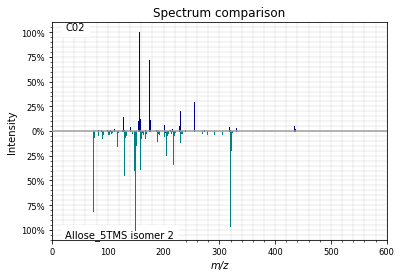

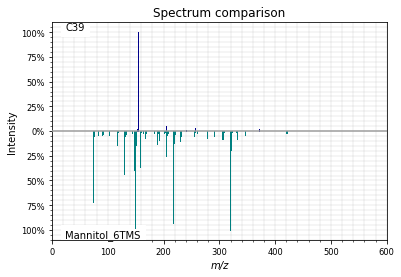

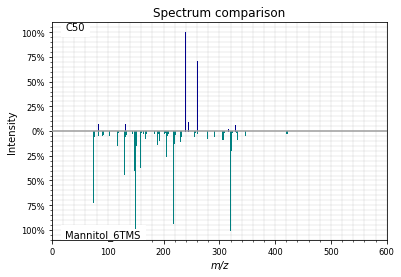

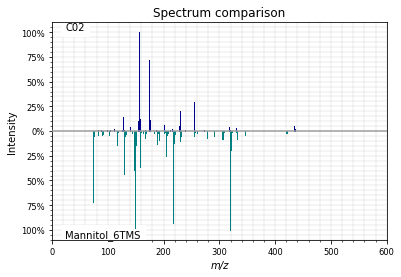

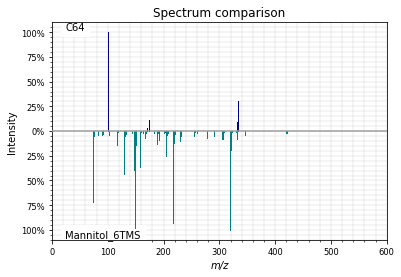

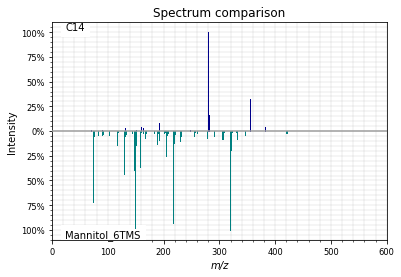

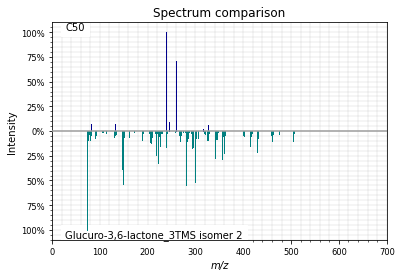

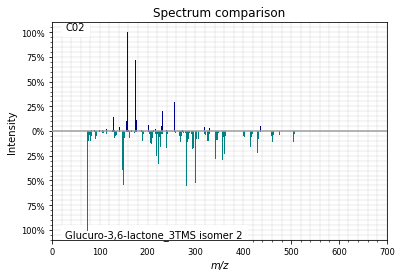

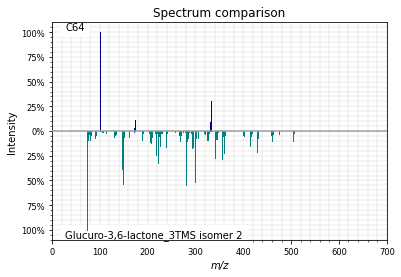

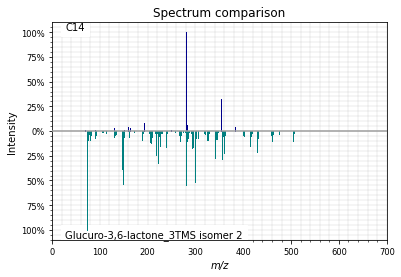

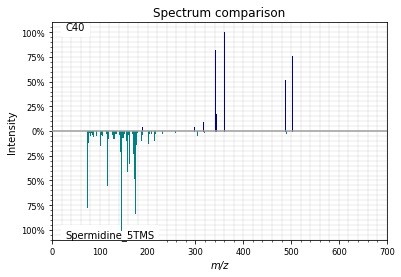

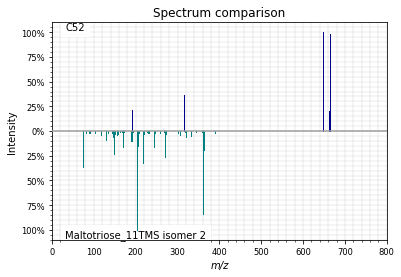

In [42]:
for spec, RT in annotated:
    if spec.metadata["compound_name"] in unmatched:
        meas = get_close(RT,measured)
        
        for m_s in meas:
            matchms.plotting.plot_spectra_mirror(m_s, spec)
            plt.show()

152.2 149.04


<AxesSubplot: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

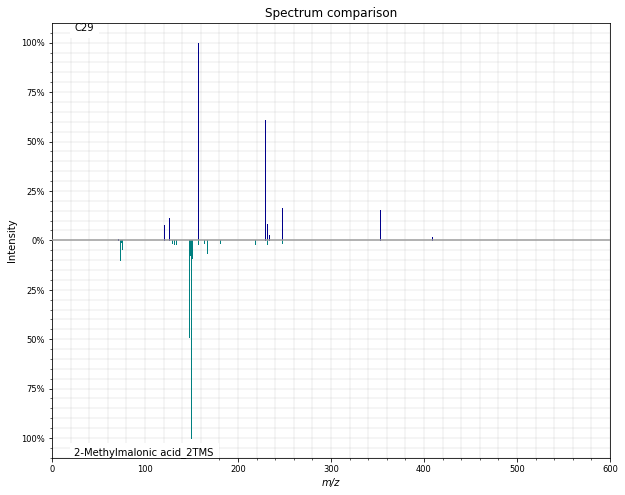

In [19]:
l =17
r = 0

print(measured[l].metadata["retention_time"], annotated[r][1])

fig,ax = plt.subplots(1, 1, figsize=(10, 8))
# matchms.plotting.plot_spectrum(measured[l], ax=ax[0])
# matchms.plotting.plot_spectrum(annotated[r][0], ax=ax[1])
matchms.plotting.plot_spectra_mirror(measured[l],annotated[r][0])

In [20]:
results_meas = [[ "out", "part"], # prolly together with 1
                [ "out", "part"], # prolly together with 0
                ["out"],
                ["out", "part"],
                ["FP", "part"], # should be together with previous one
                ["out", "FP"], # maybe also together with previous one
                ["out"],
                ["out"],
                ["out"],
                
# 12-15 are one compound on 

SyntaxError: unexpected EOF while parsing (<ipython-input-20-fea7bfe25b29>, line 11)

In [ ]:
g = set(ground["Metabolite name"]) 
l = set([x.metadata["compound_name"] for x in library])

In [ ]:
g -l 

In [ ]:
g